In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import sys
import numpy as np
import cmocean.cm as ocm
import gsw


proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(proj_dir,'data','analysis','interim')
src_dir = os.path.join(proj_dir,'src')
fig_dir = os.path.join(proj_dir,'reports','devel','figures')

sys.path.append(src_dir)
%load_ext autoreload
%autoreload 1

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

#from tools.roms_ds_tools import make_depth_single_time,make_cartesian_grid_3D_single_time
#%aimport tools.roms_ds_tools

from log_progress import log_progress
from unesco import unesco

#from visualization.shiftedColorMap import shiftedColorMap
#from tools.calc_z import calc_z
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
#import tools.make_sose_ds as sose_ds
#from tools.regrid import regrid

In [2]:
# Number of temperature and salinity bins
num_bins = 1000
# Bounds on temperature and salinity bins (pre-computed, change if needed)
min_salt = 32.1
max_salt = 35.2
min_temp = -3.5
max_temp = 4

temp_bins = np.linspace(min_temp, max_temp, num=num_bins)
# Calculate centres of temperature bins (for plotting)
temp_centres = 0.5*(temp_bins[:-1] + temp_bins[1:])
# Repeat for salinity
salt_bins = np.linspace(min_salt, max_salt, num=num_bins)
salt_centres = 0.5*(salt_bins[:-1] + salt_bins[1:])

freezing_pt_roms = salt_centres/(-18.48 + 18.48/1e3*salt_centres)
salt_2d, temp_2d = np.meshgrid(salt_centres, temp_centres)

density = unesco(temp_2d, salt_2d, np.zeros(np.shape(temp_centres)))-1000
# Density contours to plot
density_lev = np.arange(26.6, 28.4, 0.2)

# Functions

In [3]:
def calc_dx_dy(longitude,latitude,shape,radius=6370997.):
    ''' This definition calculates the distance 
        between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes 
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D arrays for latitude and longitude
        
        Returns: dx, dy; 2D arrays of distances 
                       between grid points in the x and y direction in meters 
    '''
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(a=radius,b=radius)
    else:
        g = Geod(ellps=shape)
    
    dx = np.empty(latitude.shape)
    dy = np.zeros(longitude.shape)
    
    for i in range(latitude.shape[1]):
        for j in range(latitude.shape[0]-1):
            _, _, dx[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j+1,i],latitude[j+1,i])
    dx[j+1,:] = dx[j,:]
    
    for i in range(latitude.shape[1]-1):
        for j in range(latitude.shape[0]):
            _, _, dy[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j,i+1],latitude[j,i+1])
    dy[:,i+1] = dy[:,i]
    
    return dx, dy

In [4]:
def plot_ts(ts_vals,title,min_salt = 33.2,max_salt = 35, min_temp = -3.5, max_temp = 3.8, save=False):

    max_depth = ts_vals.max()
    bounds = np.linspace(0, max_depth**(1.0/2.5), num=100)**2.5
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    manual_locations = [(33.4, 3.0), (33.65, 3.0), (33.9, 3.0), (34.2, 3.0), (34.45, 3.5), (34.65, 3.25), (34.9, 3.0), (35, 1.5)]
    
    plt.close()
    fig,ax = plt.subplots(figsize=(10,18))

    img = ax.pcolor(salt_centres,temp_centres,ts_vals, norm=norm, vmin=0, vmax=max_depth, cmap='jet')
    ax.plot(salt_centres, freezing_pt_roms, color='black', linestyle='dashed')
    cs = ax.contour(salt_centres, temp_centres, density, density_lev, linestyles='dotted',colors='gray')
    ax.clabel(cs, inline=1, fontsize=24, fmt='%1.1f', manual=manual_locations)#, colors=(0.6,0.6,0.6)
    ax.set_xlim([min_salt, max_salt])
    ax.set_ylim([min_temp, max_temp])
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    ax.set_xlabel('Salinity (psu)',size=24)
    ax.set_ylabel('Temperature ($^{\circ}$C)',size=24)

    ax.set_title(title, size=24)

    
    # Add a colourbar on the right
    #cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6])
    cbar = plt.colorbar(img, ax=ax, ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label(label='Depth in m',weight='bold',size=24)

    if save:
        plt.savefig(os.path.join(fig_dir,title+'_ts_65.png'),transparent=True,dpi=300,bbox_inches = "tight")
    plt.show()

# WOA18

In [5]:
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_t15_04.nc')
woa_t = xr.open_dataset(woa_path,decode_times=False).squeeze()
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_s15_04.nc')
woa_s = xr.open_dataset(woa_path,decode_times=False).squeeze()

In [6]:
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

mask_onshelf_waom = (mask_shelf['Total Antarctica']==1) & (grd.zice==0)
mask_offshelf_waom = (~mask_onshelf_waom) & (grd.mask_rho==1)

import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

mask_offshelf_woa = regrid(mask_offshelf_waom)
mask_onshelf_woa = regrid(mask_onshelf_waom)

Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc


In [26]:
mask = (~woa_s.s_an.isnull()==1) & (mask_onshelf_woa == 1)
mask

<xarray.DataArray (depth: 102, lat: 101, lon: 1440)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
    time     float32 79.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5200.0 5300.0 5400.0 5500.0
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... -65.375 -65.125 -64.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875

In [28]:
t = woa_t.t_an
SP = woa_s.s_an

lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

lon_2d,lat_2d = np.meshgrid(woa_t.lon,woa_t.lat)
#mask = np.zeros_like(lat_2d,dtype=int)
#mask[lat_2d < -65] = 1

lat_min = lat_2d.min()
lat_max = lat_2d.max()
lon_min = lon_2d.min()
lon_max = lon_2d.max()

temp = woa_t.pt
salt = woa_s.s_an
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],t.lon.size,axis=2)
                     
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

d = t.depth.values
d_l = ((d[1:]-d[:-1])/2)+d[:-1]
dz = np.zeros_like(t.depth)
dz[0] = d_l[0]-d[0]
dz[1:-1] = d_l[1:]-d_l[:-1]
dz[-1] = (d[-1]-d_l[-1])*2

dz_2d = np.repeat(dz[:,np.newaxis],t.lat.size,axis=1)
dz_3d = np.repeat(dz_2d[:,:,np.newaxis],t.lon.size,axis=2)

dV = dx*dy*dz_3d

# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
woa_ts = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

#mask = ~woa_s.s_an.isnull()
#ask = (~woa_s.s_an.isnull()==1) & (mask_onshelf_woa == 1)
mask = (~woa_s.s_an.isnull()==1) & (mask_offshelf_woa == 1)
# Loop over 2D grid boxes
                     
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
        if mask[0,j,i]:
            for k in np.arange(woa_t.depth.size):
                if mask[k,j,i]:
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp[k,j,i].values)[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt[k,j,i].values)[0][0] - 1
                    # Integrate depth*dV in this bin
                    woa_ts[temp_index, salt_index] += depth_3d[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
woa_ts = np.ma.masked_where(volume ==0, woa_ts)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
woa_ts /= volume
                     
out_path = os.path.join(int_dir,'ts_vals_woa_65_offshelf.npy')
woa_ts.dump(out_path)

In [ ]:
#woa_ts = np.load(os.path.join(int_dir,'ts_vals_woa_65.npy'),allow_pickle=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


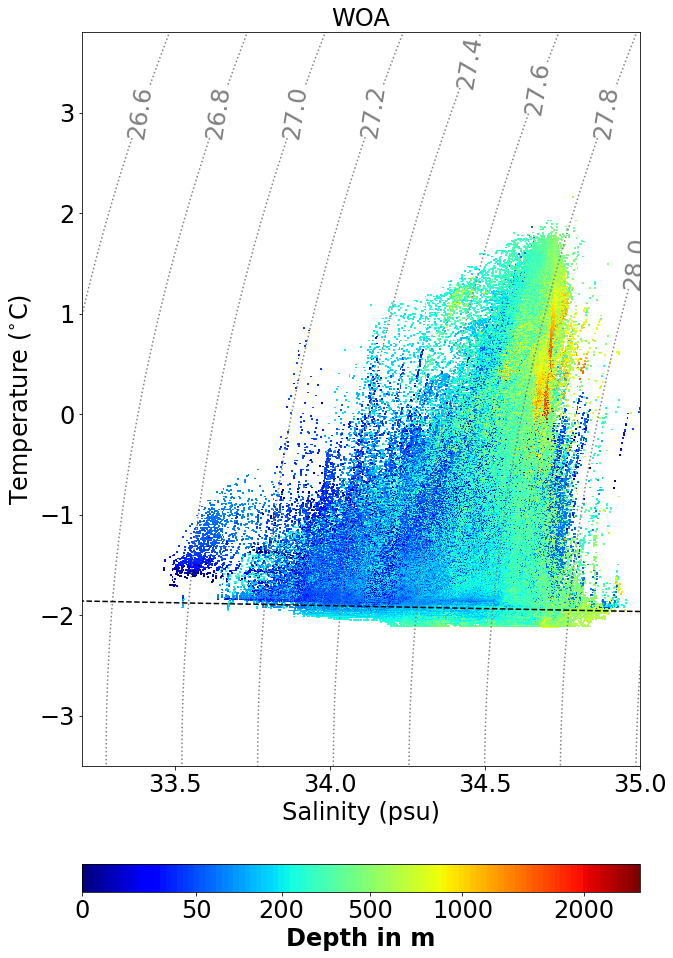

In [83]:
plot_ts(woa_ts,'WOA',save=False)

# WAOM ROMS GRID

In [5]:
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

In [15]:
temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_DJFavg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_DJFavg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_DJFavg.nc')
temp_DJF = xr.open_dataset(temp_path).temp.squeeze()
salt_DJF = xr.open_dataset(salt_path).salt.squeeze()
zeta_DJF = xr.open_dataset(zeta_path).zeta.squeeze()

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')

temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()
zeta = xr.open_dataset(zeta_path).zeta.squeeze()

In [7]:
def make_ts_vals(grd,temp,salt,depth,dV,mask):
    
    xi_2d,eta_2d = np.meshgrid(grd.xi_rho.values,grd.eta_rho.values)
    
    eta_min = eta_2d[mask[0]].min()
    eta_max = eta_2d[mask[0]].max()
    xi_min = xi_2d[mask[0]].min()
    xi_max = xi_2d[mask[0]].max()
    
    temp = temp.values
    salt = salt.values
    depth = depth.values
    dV = dV.values

    bound_mask = (temp < max_temp) & (temp > min_temp) & \
                 (salt > min_salt) & (salt < max_salt)

    # Set up 2D arrays of temperature bins x salinity bins to hold average
    # depth of water masses, weighted by volume
    ts_vals = np.zeros([np.size(temp_centres), np.size(salt_centres)])
    # Also arrays to integrate volume
    volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])
    
    # Loop over 2D grid boxes
    for j in log_progress(np.arange(eta_min,eta_max+1,dtype=int)):
        for i in np.arange(xi_min,xi_max+1,dtype=int):
            # Check for land mask
            if mask[0,j,i]:
                for k in np.arange(grd.s_rho.size):
                    if (bound_mask[k,j,i]==1) & (mask[k,j,i]==1):
                        # Figure out which bins this falls into
                        temp_index = np.nonzero(temp_bins > temp[k,j,i])[0][0] - 1
                        salt_index = np.nonzero(salt_bins > salt[k,j,i])[0][0] - 1
                        # Integrate depth*dV in this bin
                        ts_vals[temp_index, salt_index] += -depth[k,j,i]*dV[k,j,i]
                        volume[temp_index, salt_index] += dV[k,j,i]

    # Mask bins with zero volume
    ts_vals = np.ma.masked_where(volume ==0, ts_vals)
    volume = np.ma.masked_where(volume ==0, volume)
    # Convert depths from integrals to volume-averages
    ts_vals /= volume

    return ts_vals

In [24]:
mask = (grd.mask_rho == 1) & (grd.zice == 0) & (grd.lat_rho < -65)
#mask[0:50]=0
#mask[-50:-1]=0
#mask_3d = np.repeat(mask.values[np.newaxis,:,:],grd.s_rho.size,axis=0)
#mask_3d[30:,~mask_shelf['Total Antarctica']]=0

waom_ts_noMask = make_ts_vals(grd,temp,salt,grd.z,grd.dV,mask_3d)

#out_path = os.path.join(int_dir,'ts_vals_waom_65_exclSurf.npy')
#waom_ts.dump(out_path)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [25]:
out_path = os.path.join(int_dir,'ts_vals_waom_65_exclSurf_noMask.npy')
waom_ts.dump(out_path)

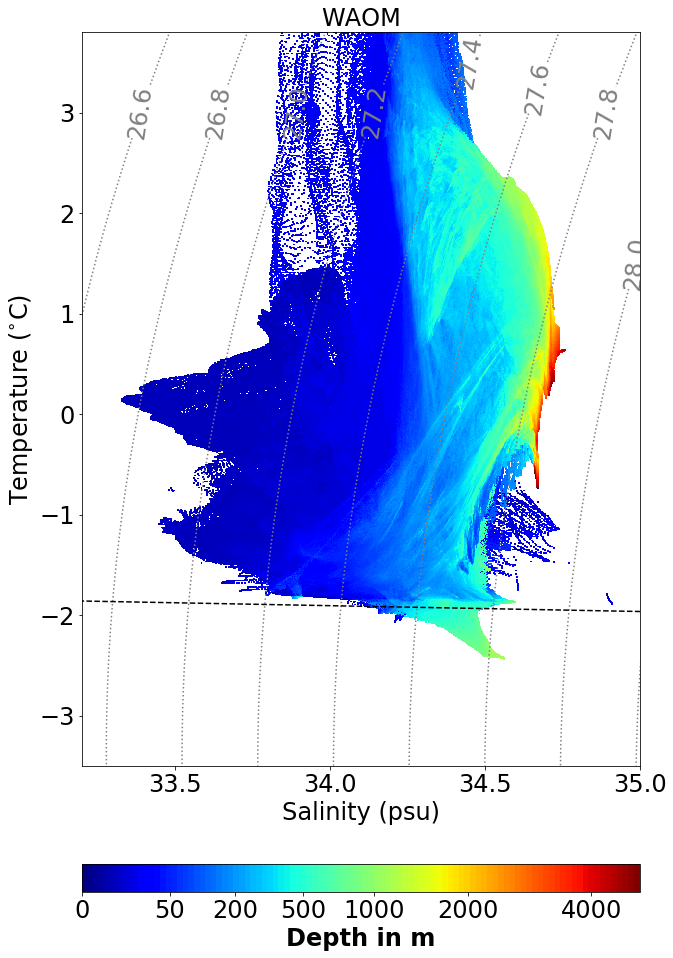

In [10]:
plot_ts(waom_ts,'WAOM',save=False)

In [21]:
in_path = os.path.join(int_dir,'ts_vals_waom_65_exclSurf.npy')
waom_ts_summer = np.load(in_path,allow_pickle=True)

In [22]:
(waom_ts_summer != waom_ts).any()

True

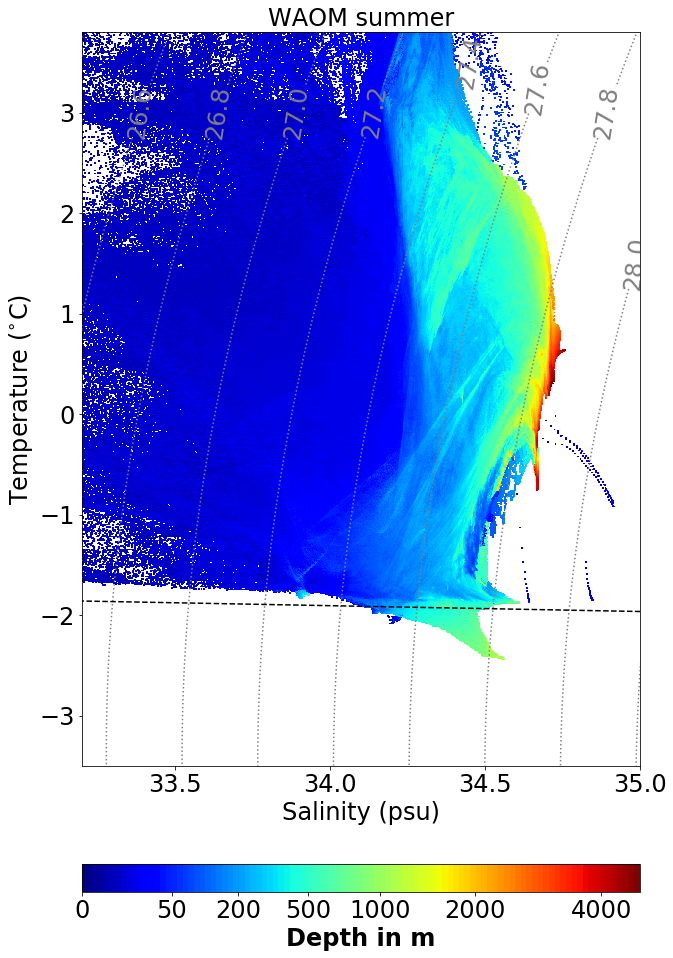

In [23]:
plot_ts(waom_ts_summer,'WAOM summer',save=False)

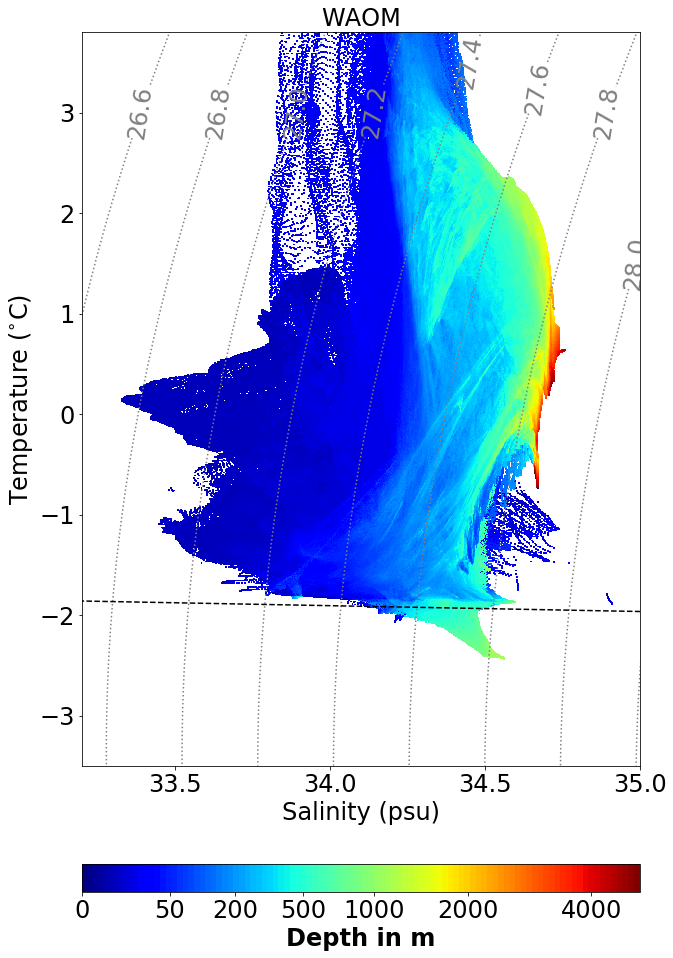

In [26]:
plot_ts(waom_ts_noMask,'WAOM',save=False)

# WAOM WOA horizontal grid

In [146]:
import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

zeta_out = regrid(zeta.where(grd.zice==0))
temp_out = regrid(temp.where(grd.zice==0))
salt_out = regrid(salt.where(grd.zice==0))
depth_3d = regrid(grd.z.where(grd.zice==0))
dz_out = regrid(grd.dz.where(grd.zice==0))

lon_2d,lat_2d = np.meshgrid(zeta_out.lon,zeta_out.lat)
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

dV = dx*dy*dz_out

Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc


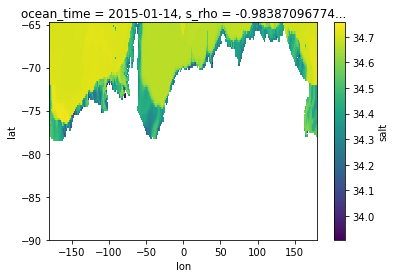

In [413]:
salt_out[0].plot()

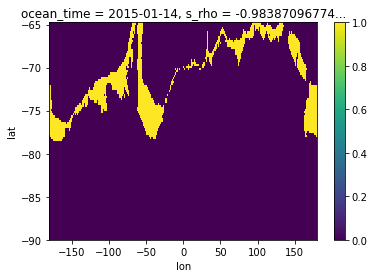

In [43]:
mask = (mask_onshelf_woa == 1) & (~temp_out[0].isnull()==1)
mask.plot()

In [45]:
lon_2d,lat_2d = np.meshgrid(zeta_out.lon,zeta_out.lat)
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

dV = dx*dy*dz_out

# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
waom_ts = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

bound_mask = (temp_out < max_temp) & (temp_out > min_temp) & \
             (salt_out > min_salt) & (salt_out < max_salt)

mask = (~temp_out[0].isnull()==1) & (mask_onshelf_woa==1)
# Loop over 2D grid boxes
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
        if mask[j,i]:
            for k in np.arange(temp.s_rho.size):
                #if (bound_mask[k,j,i]==1) & (mask_3d_out[k,j,i]==1):
                if bound_mask[k,j,i]:
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp_out[k,j,i].values)[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt_out[k,j,i].values)[0][0] - 1
                    # Integrate depth*dV in this bin
                    waom_ts[temp_index, salt_index] += -depth_3d[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
waom_ts = np.ma.masked_where(volume ==0, waom_ts)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
waom_ts /= volume

out_path = os.path.join(int_dir,'ts_vals_waom_onshelf_lowRes_65.npy')
waom_ts.dump(out_path)

In [432]:
#waom_ts = np.load(os.path.join(int_dir,'ts_vals_waom_lowRes_65.npy'),allow_pickle=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


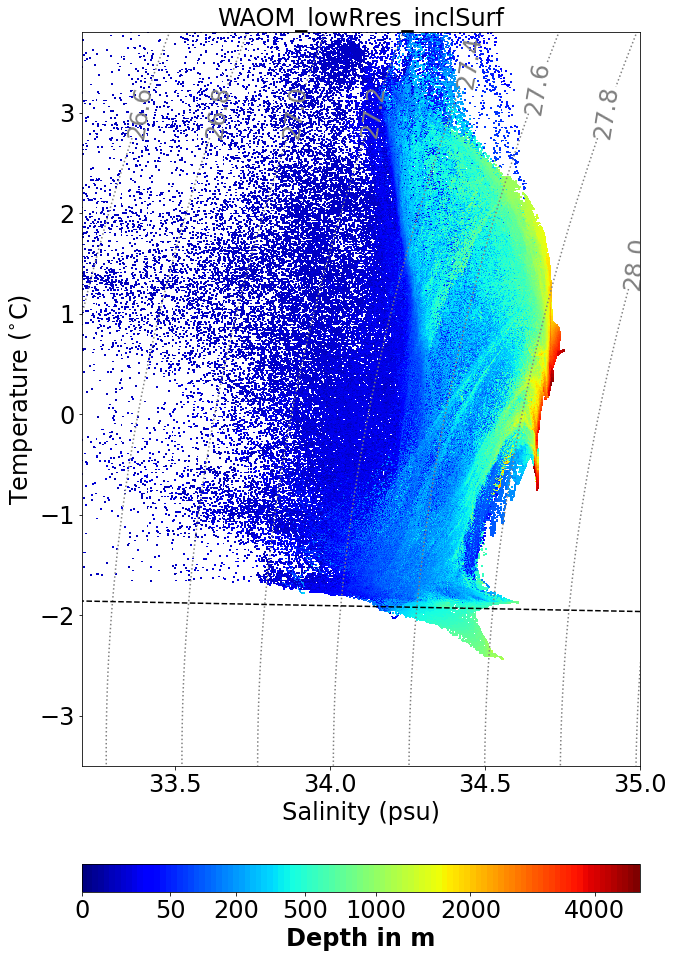

In [434]:
plot_ts(waom_ts,'WAOM_lowRres_inclSurf',save=True)

In [444]:
mask_3d_out = regrid(xr.DataArray(mask_3d,dims=('s_rho',"eta_rho",'xi_rho')))

Reuse existing file: nearest_s2d_2650x3150_101x1440.nc


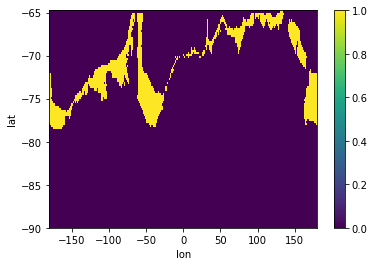

In [447]:
mask_3d_out[30].plot()

In [ ]:
lon_2d,lat_2d = np.meshgrid(zeta_out.lon,zeta_out.lat)
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

dV = dx*dy*dz_out

# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
waom_ts = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

bound_mask = (temp_out < max_temp) & (temp_out > min_temp) & \
             (salt_out > min_salt) & (salt_out < max_salt)

mask = mask_3d_out
# Loop over 2D grid boxes
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
        if mask[j,i]:
            for k in np.arange(temp.s_rho.size):
                #if (bound_mask[k,j,i]==1) & (mask_3d_out[k,j,i]==1):
                if bound_mask[k,j,i]:
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp_out[k,j,i].values)[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt_out[k,j,i].values)[0][0] - 1
                    # Integrate depth*dV in this bin
                    waom_ts[temp_index, salt_index] += -depth_3d[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
waom_ts = np.ma.masked_where(volume ==0, waom_ts)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
waom_ts /= volume

In [448]:
#out_path = os.path.join(int_dir,'ts_vals_waom_lowRes_exclSurf_65.npy')
#waom_ts.dump(out_path)
waom_ts = np.load(os.path.join(int_dir,'ts_vals_waom_lowRes_exclSurf_65.npy'),allow_pickle=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


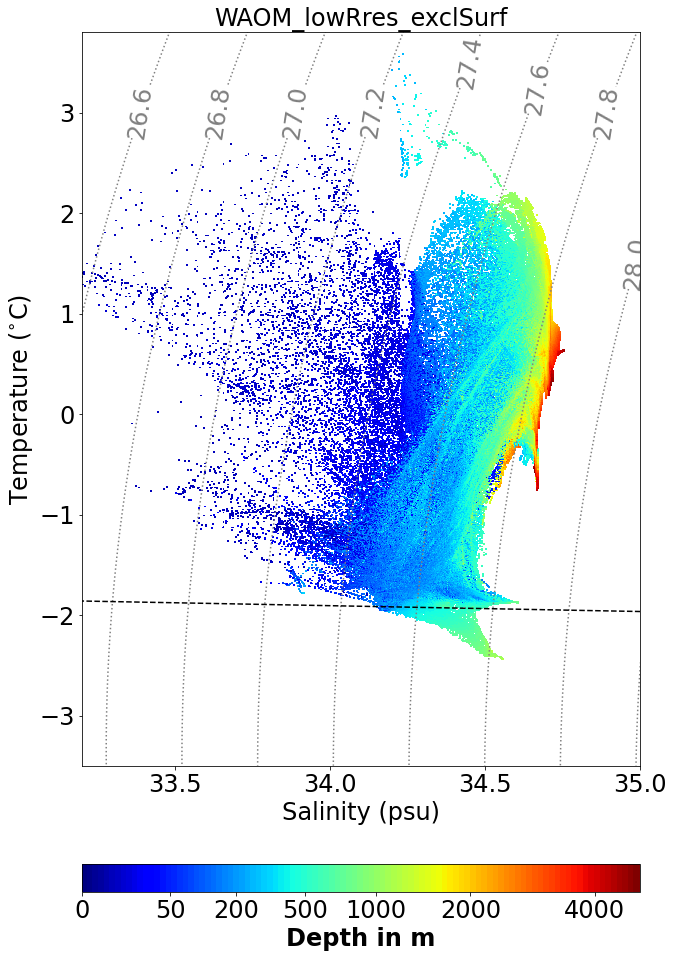

In [450]:
plot_ts(waom_ts,'WAOM_lowRres_exclSurf',save=True)

# WAOM WOA full 3d grid

In [18]:
import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

temp_out = regrid(temp.where(grd.zice==0))
salt_out = regrid(salt.where(grd.zice==0))
depth_3d = regrid(grd.z.where(grd.zice==0))

Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
Reuse existing file: nearest_s2d_2650x3150_101x1440.nc


In [19]:
from scipy import interpolate

def interp_depth(waom_out2d,mask_2d,mask_3d):
    waom_out3d = woa_t.t_an.copy()
    for lat in log_progress(np.arange(woa_t.lat.size)):
        for lon in np.arange(woa_t.lon.size):
            if mask_2d[lat,lon]:
                f = interpolate.interp1d(-depth_3d[:,lat,lon],waom_out2d[:,lat,lon],
                                         fill_value='extrapolate',kind='nearest')
                waom_out3d[:,lat,lon] = f(woa_t.depth)
        
    return waom_out3d.where(mask_3d)

mask2d = mask_offshelf_woa
mask3d = (mask_offshelf_woa == 1) & (~woa_s.s_an.isnull()==1)

temp_out3d = interp_depth(temp_out,mask2d,mask3d)
salt_out3d = interp_depth(salt_out,mask2d,mask3d)

In [20]:
t = woa_t.t_an

lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
lon_2d,lat_2d = np.meshgrid(woa_t.lon,woa_t.lat)
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],t.lon.size,axis=2)
                     
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

d = t.depth.values
d_l = ((d[1:]-d[:-1])/2)+d[:-1]
dz = np.zeros_like(t.depth)
dz[0] = d_l[0]-d[0]
dz[1:-1] = d_l[1:]-d_l[:-1]
dz[-1] = (d[-1]-d_l[-1])*2

dz_2d = np.repeat(dz[:,np.newaxis],t.lat.size,axis=1)
dz_3d = np.repeat(dz_2d[:,:,np.newaxis],t.lon.size,axis=2)

dV = dx*dy*dz_3d

# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
woa_ts = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

#mask = ~woa_s.s_an.isnull()
#mask = (~woa_s.s_an.isnull()==1) & (mask_onshelf_woa == 1)
mask = (~woa_s.s_an.isnull()==1) & (mask_offshelf_woa == 1)
# Loop over 2D grid boxes

bound_mask = (temp_out3d < max_temp) & (temp_out3d > min_temp) & \
             (salt_out3d > min_salt) & (salt_out3d < max_salt)
                     
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
        if mask[0,j,i]:
            for k in np.arange(woa_t.depth.size):
                if (mask[k,j,i] == 1) & (bound_mask[k,j,i] == 1):
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp_out3d[k,j,i].values)[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt_out3d[k,j,i].values)[0][0] - 1
                    # Integrate depth*dV in this bin
                    woa_ts[temp_index, salt_index] += depth_3d[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
woa_ts = np.ma.masked_where(volume ==0, woa_ts)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
woa_ts /= volume
                     
out_path = os.path.join(int_dir,'ts_vals_waomOnWoa_65_offshelf.npy')
woa_ts.dump(out_path)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


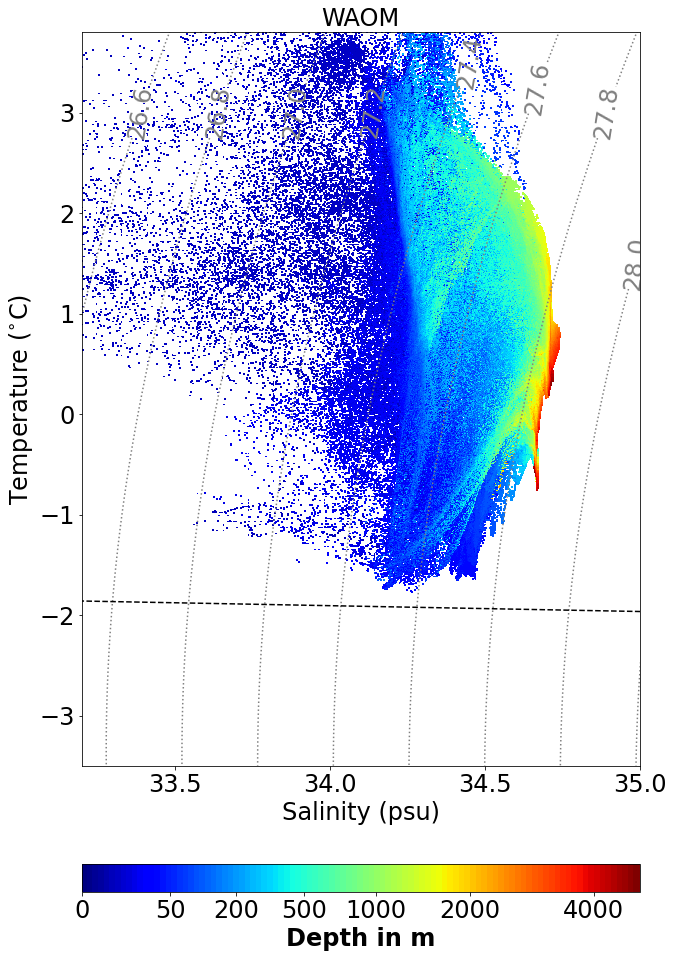

In [21]:
plot_ts(woa_ts,'WAOM',save=False)

# ECCO

In [49]:
ecco_path = os.path.join(proj_dir,'data','preprocessing','external','ecco2','THETA.nc','THETA.1440x720x50.2007??.nc')
ecco_t = xr.open_mfdataset(ecco_path,decode_times=False).THETA.sel({'LATITUDE_T':slice(-80,-65),'TIME':[181,182,192]}).mean('TIME').load()
ecco_path = os.path.join(proj_dir,'data','preprocessing','external','ecco2','SALT.nc','SALT.1440x720x50.2007??.nc')
ecco_s = xr.open_mfdataset(ecco_path,decode_times=False).SALT.sel({'LATITUDE_T':slice(-80,-65),'TIME':[181,182,192]}).mean('TIME').load()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [50]:
lon = ecco_t.LONGITUDE_T.values.copy()
lon[lon>180]-=360
lat = ecco_t.LATITUDE_T.values
depth = ecco_t.DEPTH_T.values

lat_2d,depth_2d = np.meshgrid(lat,depth)

lon_2d,lat_2d = np.meshgrid(lon,lat)
#mask = np.zeros_like(lat_2d,dtype=int)
#mask[lat_2d < -65] = 1

lat_min = lat_2d.min()
lat_max = lat_2d.max()
lon_min = lon_2d.min()
lon_max = lon_2d.max()

temp = ecco_t.values
salt = ecco_s.values
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],lon.size,axis=2)

In [71]:
def regrid(da):
    ecco_tmp = ecco_t.rename({'LATITUDE_T':'lat','LONGITUDE_T':'lon'})
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,ecco_tmp,'nearest_s2d',reuse_weights=True)
    return regridder(da)

mask_offshelf_ecco = regrid(mask_offshelf_waom).rename({'lat':'LATITUDE_T','lon':'LONGITUDE_T'})
mask_onshelf_ecco = regrid(mask_onshelf_waom).rename({'lat':'LATITUDE_T','lon':'LONGITUDE_T'})

Reuse existing file: nearest_s2d_2650x3150_60x1440.nc
Reuse existing file: nearest_s2d_2650x3150_60x1440.nc


In [ ]:
from scipy import interpolate

def interp_depth(waom_out2d,mask_2d,mask_3d):
    waom_out3d = woa_t.t_an.copy()
    for lat in log_progress(np.arange(woa_t.lat.size)):
        for lon in np.arange(woa_t.lon.size):
            if mask_2d[lat,lon]:
                f = interpolate.interp1d(-depth_3d[:,lat,lon],waom_out2d[:,lat,lon],
                                         fill_value='extrapolate',kind='nearest')
                waom_out3d[:,lat,lon] = f(woa_t.depth)
        
    return waom_out3d.where(mask_3d)

mask2d = mask_offshelf_woa
mask3d = (mask_offshelf_woa == 1) & (~woa_s.s_an.isnull()==1)

temp_out3d = interp_depth(temp_out,mask2d,mask3d)
salt_out3d = interp_depth(salt_out,mask2d,mask3d)

In [67]:
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

d = depth
d_l = ((d[1:]-d[:-1])/2)+d[:-1]
dz = np.zeros_like(depth)
dz[0] = d_l[0]-d[0]
dz[1:-1] = d_l[1:]-d_l[:-1]
dz[-1] = (d[-1]-d_l[-1])*2

dz_2d = np.repeat(dz[:,np.newaxis],lat.size,axis=1)
dz_3d = np.repeat(dz_2d[:,:,np.newaxis],lon.size,axis=2)

dV = dx*dy*dz_3d

In [73]:
# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
ecco_ts = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

#mask = ~ecco_s.isnull()
mask = (~ecco_s.isnull()==1) & (mask_offshelf_ecco == 1)
bound_mask = (temp < max_temp) & (temp > min_temp) & \
             (salt > min_salt) & (salt < max_salt)
# Loop over 2D grid boxes
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
        if mask[0,j,i]:
            for k in np.arange(depth.size):
                if (mask[k,j,i]==1) & (bound_mask[k,j,i]==1):
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp[k,j,i])[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt[k,j,i])[0][0] - 1
                    # Integrate depth*dV in this bin
                    ecco_ts[temp_index, salt_index] += depth_3d[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
ecco_ts = np.ma.masked_where(volume ==0, ecco_ts)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
ecco_ts /= volume

out_path = os.path.join(int_dir,'ts_vals_ecco_65_offshelf.npy')
ecco_ts.dump(out_path)

In [228]:
ecco_ts = np.load(os.path.join(int_dir,'ts_vals_ecco_65.npy'),allow_pickle=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


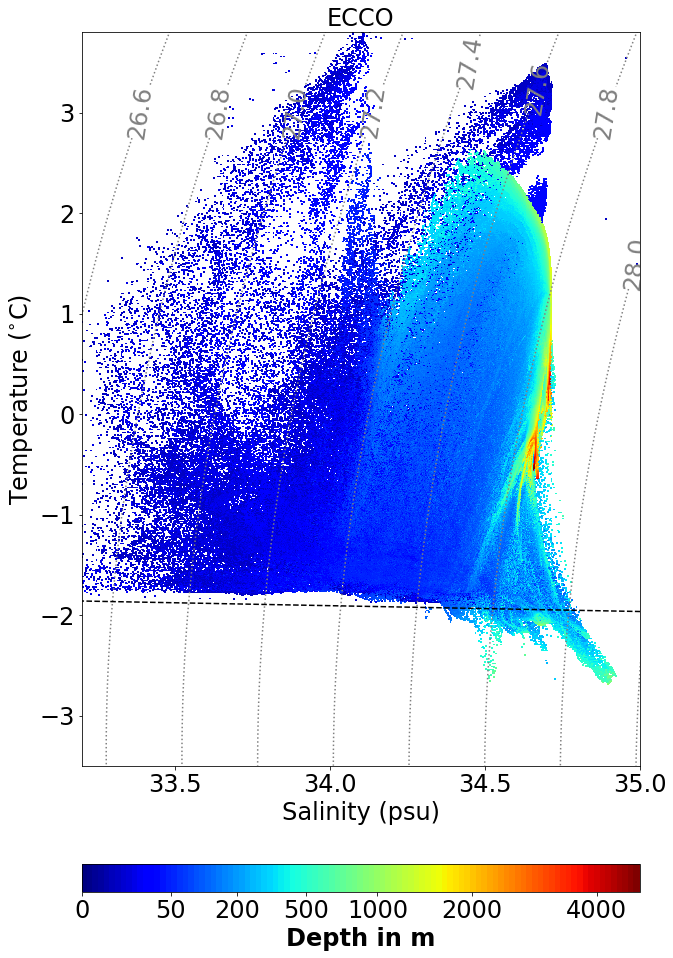

In [243]:
plot_ts(ecco_ts,'ECCO',save=True)

# plotting

## off-shelf

In [5]:
woa_ts = np.load(os.path.join(int_dir,'ts_vals_woa_65_offshelf.npy'),allow_pickle=True)
waom_ts = np.load(os.path.join(int_dir,'ts_vals_waomOnWoa_65_offshelf.npy'),allow_pickle=True)
ecco_ts = np.load(os.path.join(int_dir,'ts_vals_ecco_65_offshelf.npy'),allow_pickle=True)

In [124]:
max(ecco_t.DEPTH_T.max(),woa_t.depth.max())

<xarray.DataArray 'DEPTH_T' ()>
array(5906.25, dtype=float32)

In [6]:
def ax_ts(ax,ts_vals,title,min_salt = 33.2,max_salt = 35.1, min_temp = -3.0, max_temp = 3.8, max_depth= 5900, save=False):

    bounds = np.linspace(0, max_depth**(1.0/2.5), num=100)**2.5
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    manual_locations = [(33.4, 3.0), (33.65, 3.0), (33.9, 3.0), (34.2, 3.0), (34.45, 3.5), (34.65, 3.25), (34.9, 3.0), (35, 1.5)]

    img = ax.pcolor(salt_centres,temp_centres,ts_vals, norm=norm, vmin=0, vmax=max_depth, cmap='jet')
    ax.plot(salt_centres, freezing_pt_roms, color='black', linestyle='dashed')
    cs = ax.contour(salt_centres, temp_centres, density, density_lev, linestyles='dotted',colors='gray')
    ax.clabel(cs, inline=1, fmt='%1.1f', manual=manual_locations)#, colors=(0.6,0.6,0.6)
    ax.set_xlim([min_salt, max_salt])
    ax.set_ylim([min_temp, max_temp])
    #ax.tick_params(axis='x', labelsize=24)
    #ax.tick_params(axis='y', labelsize=24)

    #ax.set_xlabel('Salinity (psu)')
    #ax.set_ylabel('Temperature ($^{\circ}$C)')

    ax.set_title(title, size=12, weight='bold')

    
    # Add a colourbar on the right
    #cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6])
    #cbar = plt.colorbar(img, ax=ax, ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
    #cbar.ax.tick_params(labelsize=24)
    #cbar.set_label(label='Depth in m',weight='bold',size=24)

    return ax,img

def wm_label(ax,salt,temp,label):
    ax.text( salt, temp,label, ha='center', va='center',transform=ax.transData )
    return ax

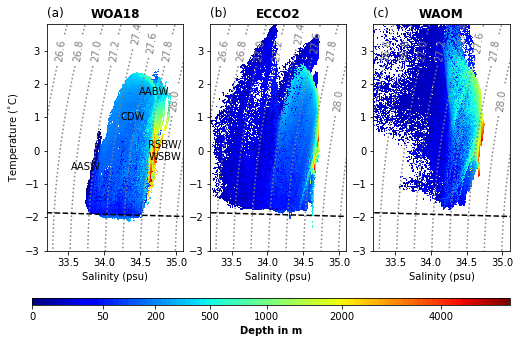

In [9]:
import string
fig,axes = plt.subplots(ncols=3,figsize = (8.29, 5))

ax1,ax2,ax3 = axes.flatten()

ax1,img = ax_ts(ax1,woa_ts,'WOA18')
ax2,img = ax_ts(ax2,ecco_ts,'ECCO2')
ax3,img = ax_ts(ax3,waom_ts,'WAOM')

ax1.set_ylabel('Temperature ($^{\circ}$C)')

ax1 = wm_label(ax1, 34.7, 1.75, 'AABW')
ax1 = wm_label(ax1, 34.4, 1.0, 'CDW')
#ax1 = wm_label(ax1, 34.3, -0.75, 'MCDW')
ax1 = wm_label(ax1, 34.85, 0. , 'RSBW/\nWSBW')
#ax1 = wm_label(ax1, 34.85, -0.75 , 'WSBW')
#ax1 = wm_label(ax1, 33.5, -2.5 , 'ISW')
ax1 = wm_label(ax1, 33.75, -0.5 , 'AASW')
#ax1 = wm_label(ax1, 34.1, -1.75 , 'LSSW')
#ax1 = wm_label(ax1, 34.7, -1.8 , 'HSSW')
                            
n=0
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('Salinity (psu)')    
    ax.text(-0.00, 1.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
    

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
cbar.set_label(label='Depth in m',weight='bold')

#plt.subplots_adjust(wspace=0.1)

out_path = os.path.join(fig_dir,'TS-WOA_ECCO_WAOM_offshelf.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

## on-shelf

In [10]:
woa_ts = np.load(os.path.join(int_dir,'ts_vals_woa_65_onshelf.npy'),allow_pickle=True)
waom_ts = np.load(os.path.join(int_dir,'ts_vals_waomOnWoa_65_onshelf.npy'),allow_pickle=True)

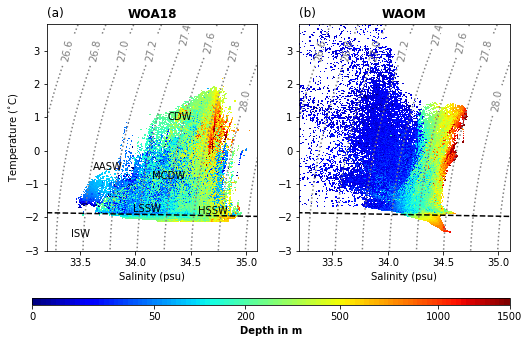

In [11]:
import string
fig,axes = plt.subplots(ncols=2,figsize = (8.29, 5))

ax1,ax2 = axes.flatten()

ax1,img = ax_ts(ax1,woa_ts,'WOA18',max_depth=1500)
ax2,img = ax_ts(ax2,waom_ts,'WAOM',max_depth=1500)

ax1.set_ylabel('Temperature ($^{\circ}$C)')


#ax1 = wm_label(ax1, 34.6, 1.8, 'AABW')
ax1 = wm_label(ax1, 34.4, 1.0, 'CDW')
ax1 = wm_label(ax1, 34.3, -0.75, 'MCDW')
#ax1 = wm_label(ax1, 34.85, 0. , 'RSBW')
#ax1 = wm_label(ax1, 34.85, -0.75 , 'WSBW')
ax1 = wm_label(ax1, 33.5, -2.5 , 'ISW')
ax1 = wm_label(ax1, 33.75, -0.5 , 'AASW')
ax1 = wm_label(ax1, 34.1, -1.75 , 'LSSW')
ax1 = wm_label(ax1, 34.7, -1.8 , 'HSSW')


n=0
for ax in [ax1,ax2]:
    ax.set_xlabel('Salinity (psu)')    
    ax.text(-0.00, 1.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
    

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,1500], orientation="horizontal", pad=0.1)
cbar.set_label(label='Depth in m',weight='bold')

#plt.subplots_adjust(wspace=0.1)

out_path = os.path.join(fig_dir,'TS-WOA_WAOM_onshelf.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

# WOA18 1deg

In [24]:
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_t15_01.nc')
woa_t = xr.open_dataset(woa_path,decode_times=False).squeeze()
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_s15_01.nc')
woa_s = xr.open_dataset(woa_path,decode_times=False).squeeze()

In [79]:
t = woa_t.t_an
SP = woa_s.s_an

lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

In [86]:
lon_2d,lat_2d = np.meshgrid(woa_t.lon,woa_t.lat)
#mask = np.zeros_like(lat_2d,dtype=int)
#mask[lat_2d < -65] = 1

lat_min = lat_2d.min()
lat_max = lat_2d.max()
lon_min = lon_2d.min()
lon_max = lon_2d.max()

temp = woa_t.pt
salt = woa_s.s_an
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],t.lon.size,axis=2)

In [184]:
def calc_dx_dy(longitude,latitude,shape,radius=6370997.):
    ''' This definition calculates the distance 
        between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes 
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D arrays for latitude and longitude
        
        Returns: dx, dy; 2D arrays of distances 
                       between grid points in the x and y direction in meters 
    '''
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(a=radius,b=radius)
    else:
        g = Geod(ellps=shape)
    
    dx = np.empty(latitude.shape)
    dy = np.zeros(longitude.shape)
    
    for i in range(latitude.shape[1]):
        for j in range(latitude.shape[0]-1):
            _, _, dx[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j+1,i],latitude[j+1,i])
    dx[j+1,:] = dx[j,:]
    
    for i in range(latitude.shape[1]-1):
        for j in range(latitude.shape[0]):
            _, _, dy[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j,i+1],latitude[j,i+1])
    dy[:,i+1] = dy[:,i]
    
    return dx, dy

In [142]:
dx,dy = calc_dx_dy(lon_2d,lat_2d,'WGS84')

d = t.depth.values
d_l = ((d[1:]-d[:-1])/2)+d[:-1]
dz = np.zeros_like(t.depth)
dz[0] = d_l[0]-d[0]
dz[1:-1] = d_l[1:]-d_l[:-1]
dz[-1] = (d[-1]-d_l[-1])*2

dz_2d = np.repeat(dz[:,np.newaxis],t.lat.size,axis=1)
dz_3d = np.repeat(dz_2d[:,:,np.newaxis],t.lon.size,axis=2)

dV = dx*dy*dz_3d

# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
woa_ts = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

mask = ~woa_s.s_an.isnull()
# Loop over 2D grid boxes
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
            for k in np.arange(woa_t.depth.size):
                if mask[k,j,i]:
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp[k,j,i].values)[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt[k,j,i].values)[0][0] - 1
                    # Integrate depth*dV in this bin
                    woa_ts[temp_index, salt_index] += depth_3d[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
woa_ts = np.ma.masked_where(volume ==0, woa_ts)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
woa_ts /= volume

In [247]:
#out_path = os.path.join(int_dir,'ts_vals_woa_65.npy')
#woa_ts.dump(out_path)
woa_ts = np.load(os.path.join(int_dir,'ts_vals_woa_65.npy'),allow_pickle=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


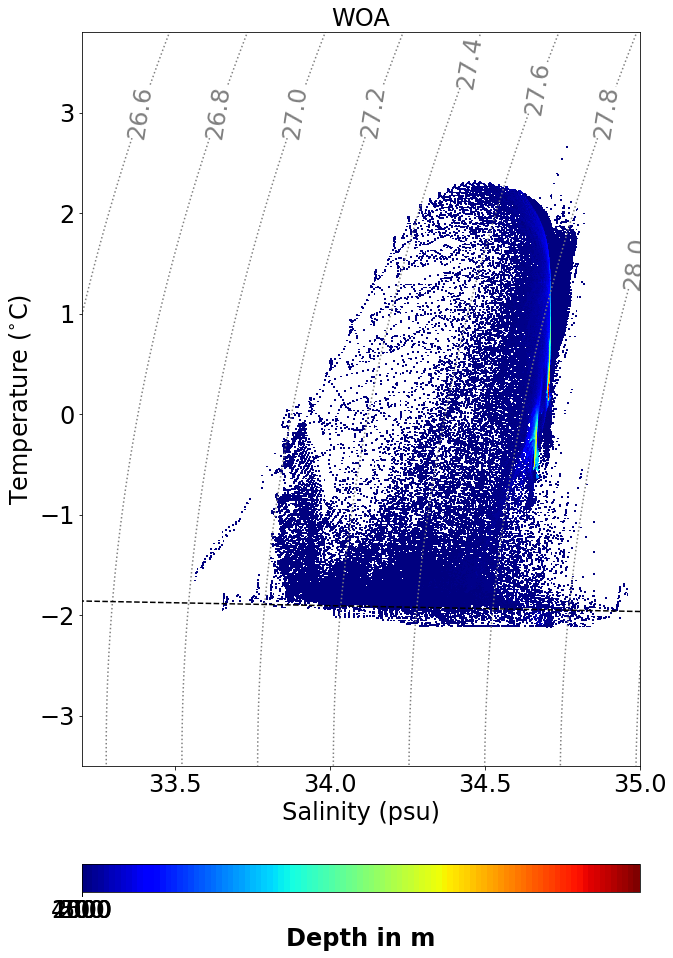

In [245]:
plot_ts(woa_ts,'WOA',save=True)